# 문제 설명

서울시에서 2015년 부터 시행한 무인 공공자전거 대여 서비스 “따릉이”는 해가 지날수록 이용하는 시민이 늘어나는 추세입니다. 하지만 2020년 9월 서울환경연합에서 진행한 ‘[자전거 이용에 관한 설문조사](http://ecoseoul.or.kr/archives/41430)’에 따르면 조사 대상 2700명 중 27%의 응답자는 따릉이 이용 시 가장 불편한 점을 대여시 따릉이가 부족한 점을 지적하였습니다. 이를 해소하기 위해 2017년부터 1월부터 2018년 11월 날씨와 따릉이 이용량 정보를 활용하여 정확한 수요량을 예측하고자 합니다.
머신러닝의 회귀 기법을 활용하여 각 날짜에 해당하는 따릉이 대여량을 예측해보세요.


## Google Drive 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 라이브러리 불러오기

In [ ]:
# MISC
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

# PREPROCESS
import missingno as msno

## 데이터 불러오기


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/잠자리/데이터크리에이터/예선/train.csv')
df = df.sort_values(by=['Date', 'Hour']).reset_index(drop=True)

# 데이터 살펴보기

## 데이터 설명

In [ ]:
df

,Date,Hour,Temperature,Rainfall,Windspeed,Humidity,Dewpoint,Snow,Visibility,Rent Amount
0,2019-06-01,0,16.1,NaN,1.3,63.0,9.0,NaN,1999,2232
1,2019-06-01,1,15.5,NaN,1.5,69.0,9.8,NaN,1693,2059
2,2019-06-01,2,15.3,NaN,1.6,74.0,10.6,NaN,1132,1616
3,2019-06-01,3,15.0,NaN,1.5,80.0,11.5,NaN,854,1128
4,2019-06-01,4,15.2,NaN,1.8,78.0,11.3,NaN,805,679
...,...,...,...,...,...,...,...,...,...,...
13116,2020-12-31,19,-7.1,NaN,2.4,58.0,-13.9,NaN,2000,1287
13117,2020-12-31,20,-7.1,NaN,3.2,59.0,-13.7,NaN,2000,996
13118,2020-12-31,21,-7.2,NaN,2.7,61.0,-13.4,NaN,2000,856
13119,2020-12-31,22,-7.4,NaN,2.5,66.0,-12.6,NaN,2000,519


데이터는 2019년 6월 1일 자정부터 2020년 12월 31일 23시까지의 날씨와 대여량 따릉이 대여수 정보를 담고 있습니다. 우리의 목적은 날씨와 시간을 통해 따릉이 대여수를 예측하는 것입니다. 실제 예측해야하는 Test data는 Train data 외의 날짜이며 공개하지 않았습니다. 데이터는 총 13,121건의 대여량을 담고 있고, 예측해야하는 데이터는 총 719 건입니다.

+ `Date` YYYY-MM-DD 형태의 날짜입니다.
+ `Hour` 시간
+ `Temperature` 섭씨 단위로 기록된 해당 날짜의 서울 평균 기온입니다.
+ `Rainfall` 해당 시간의 강수량입니다. 기입이 되지 않은 날은 비가 오지 않은 날입니다
+ `Windspeed` m/s 단위로 기록된 풍속입니다.
+ `Dewpoint` 이슬점 기온입니다.
+ `Snow` 적설량입니다. 기록되지 않은 날은 눈이 오지 않은 날입니다.
+ `Visibility` 시정, 즉 대기의 혼탁정도를 나타내는 기상요소로서, 지표면에서 정상적인 시각을 가진 사람이 목표를 식별할 수 있는 최대거리입니다. meter 단위로 되어 있습니다.
+ `Rent Amount` 시간대별 따릉이 대여수입니다. 이를 예측하면 됩니다.

## 기본 정보 확인하기

`pandas.DataFrame.info`   
+ 열 별로 이름과 결측치가 있는지, 데이터의 자료형과 데이터프레임이 차지하는 용량 등을 표현합니다.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13121 entries, 0 to 13120
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         13121 non-null  object 
 1   Hour         13121 non-null  int64  
 2   Temperature  13120 non-null  float64
 3   Rainfall     1517 non-null   float64
 4   Windspeed    13114 non-null  float64
 5   Humidity     13121 non-null  float64
 6   Dewpoint     13115 non-null  float64
 7   Snow         210 non-null    float64
 8   Visibility   13121 non-null  int64  
 9   Rent Amount  13121 non-null  int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 1.0+ MB


`pandas.DataFrame.describe`
+ 수치형 데이터를 가지는 열들에 대해서 기초적인 기술통계량들을 표시합니다. 통계량에는 평균값, 표준편차, 최대 최소값과 4분위수를 포함합니다.

In [ ]:
df.describe()

,Hour,Temperature,Rainfall,Windspeed,Humidity,Dewpoint,Snow,Visibility,Rent Amount
count,13121.000000,13120.000000,1517.00000,13114.000000,13121.000000,13115.000000,210.000000,13121.000000,13121.000000
mean,11.503544,14.322470,1.48563,2.208945,62.775703,6.614533,1.355714,1457.783401,2072.791174
std,6.921446,10.246021,3.59675,1.149318,19.602434,11.714861,1.043958,587.107702,1516.866601
min,0.000000,-12.900000,0.00000,0.000000,11.000000,-23.900000,0.000000,23.000000,5.000000
25%,6.000000,5.700000,0.00000,1.400000,48.000000,-3.200000,0.700000,980.000000,826.000000
50%,12.000000,15.500000,0.20000,2.000000,63.000000,7.500000,1.000000,1680.000000,1767.000000
75%,18.000000,23.200000,1.20000,2.900000,78.000000,16.800000,1.800000,2000.000000,2989.000000
max,23.000000,36.700000,42.10000,8.000000,100.000000,27.900000,5.500000,5000.000000,8699.000000


# 전처리

## 그래프 그리기

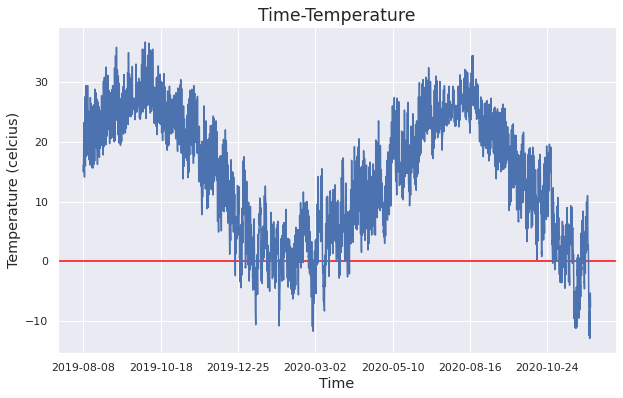

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Time-Temperature', size='x-large')
ax.set_xlabel('Time', size='large')
ax.set_ylabel('Temperature (celcius)', size='large')
index = [int(df.shape[0] * (i/8)) for i in range(8)]
ax.set_xticklabels(df['Date'][index].tolist())
ax.axhline(0, color='red')
df['Temperature'].plot(ax=ax);

## 결측값 처리

### 결측치를 확인하는 방법

In [ ]:
# pandas isna() 를 활용해 결측치 확인
df.isna().sum()

Date               0
Hour               0
Temperature        1
Rainfall       11604
Windspeed          7
Humidity           0
Dewpoint           6
Snow           12911
Visibility         0
Rent Amount        0
dtype: int64

In [ ]:
# missingno 모듈 활용하여 결측치 확인
!pip install missingno -q
import missingno as msno

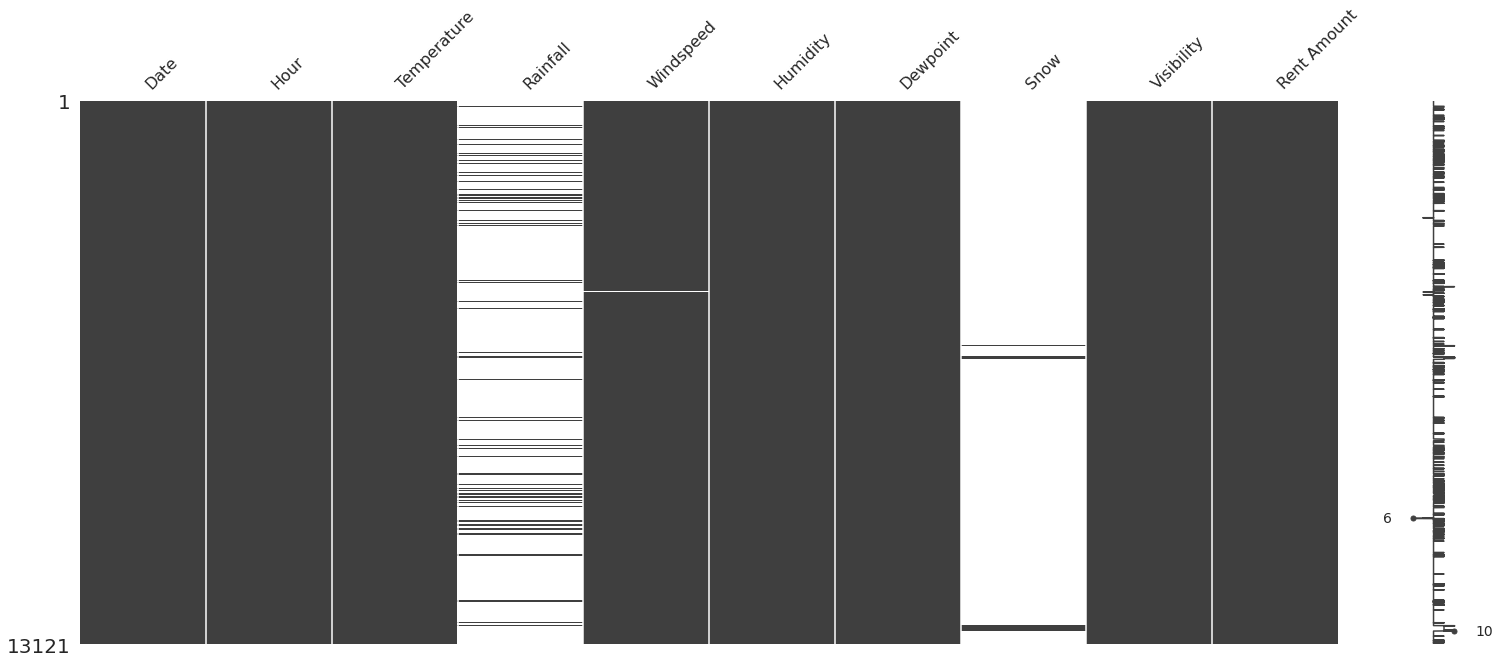

In [ ]:
msno.matrix(df)

### 결측치 채우기

결측치를 채우는 방법에는 여러 가지가 있습니다.
- `Temperature`, `Dewpoint` 기온과 이슬점은 특성상 앞뒤의 값과 비슷할 것으로 생각되네요. 이럴 때는 전후값을 활용해 보간할 수 있습니다. 이 보간은 `pandas` 모듈에서 `interpolate`를 활용하시면 됩니다. `method`에는 여러 가지 방법이 있는데 공식 홈페이지를 통해 다양한 방법들을 참고할 수 있습니다.    
[pandas - interpolate 링크](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)
- 보간 방법에는 여러 가지가 있는데, 전체값을 활용할 때는 `linear`, 결측치 주변값을 활용할 때는 `nearest`를 활용하면 좋습니다.

In [ ]:
cols = ['Temperature', 'Dewpoint', 'Windspeed']
df_fillna[cols] = df_fillna[cols].interpolate('nearest')

- `Windspeed` 풍속의 경우도 앞뒤 상황과 맞춰 사용해도 되지만, 평균값을 이용하는 것도 나쁘지 않을 것 같습니다. 이럴 때는 직접 평균치를 넣어주는 `fillna` 메소드를 활용하면 좋습니다.

- `Rainfall`, `Snow` 결측치가 아주 많습니다. 이는 데이터의 문제라기보다는, 비나 눈이 오지 않았으면 저장공간을 확보하기 위해 그냥 기록하지 않은 것 같습니다. 이럴 때는 비나 눈이 오지 않은 것으로 가정하고 0으로 채우는 것이 좋겠네요.

In [ ]:
cols = ['Rainfall', 'Snow']
df_fillna[cols] = df_fillna[cols].fillna(0)

In [ ]:
df_fillna.isna().sum()

Date           0
Hour           0
Temperature    0
Rainfall       0
Windspeed      0
Humidity       0
Dewpoint       0
Snow           0
Visibility     0
year           0
month          0
day            0
dayofweek      0
dtype: int64

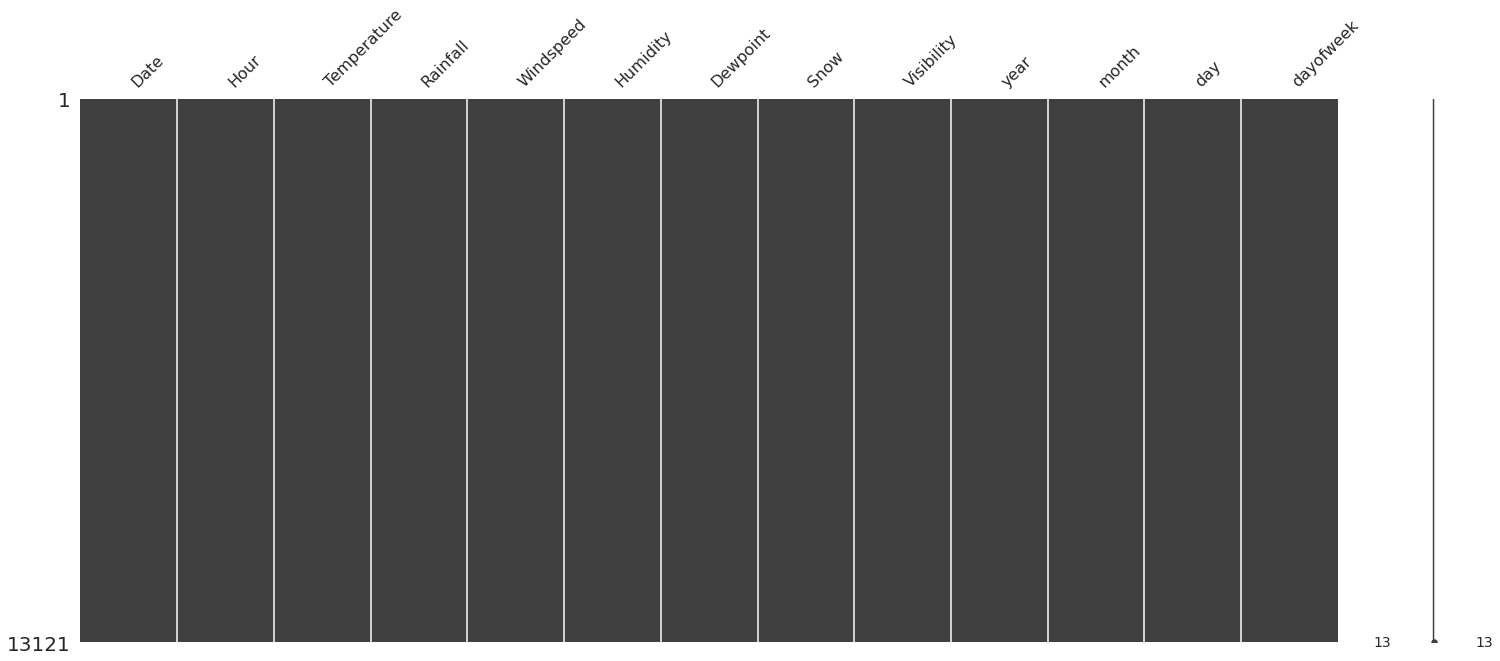

In [ ]:
msno.matrix(df_fillna);

# EDA

In [ ]:
df['y-m'] = df["Date"].str[0:-3]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df.shape

(13121, 14)

In [ ]:
df.head()

,Date,Hour,Temperature,Rainfall,Windspeed,Humidity,Dewpoint,Snow,Visibility,Rent Amount,y-m,year,month,day
0,2019-06-01,0,16.1,NaN,1.3,63.0,9.0,NaN,1999,2232,2019-06,2019,6,1
1,2019-06-01,1,15.5,NaN,1.5,69.0,9.8,NaN,1693,2059,2019-06,2019,6,1
2,2019-06-01,2,15.3,NaN,1.6,74.0,10.6,NaN,1132,1616,2019-06,2019,6,1
3,2019-06-01,3,15.0,NaN,1.5,80.0,11.5,NaN,854,1128,2019-06,2019,6,1
4,2019-06-01,4,15.2,NaN,1.8,78.0,11.3,NaN,805,679,2019-06,2019,6,1


## 각 연도별, 월별 대여량의 차이 확인

[Text(0.5, 0, 'month'), Text(0.5, 1.0, 'month')]

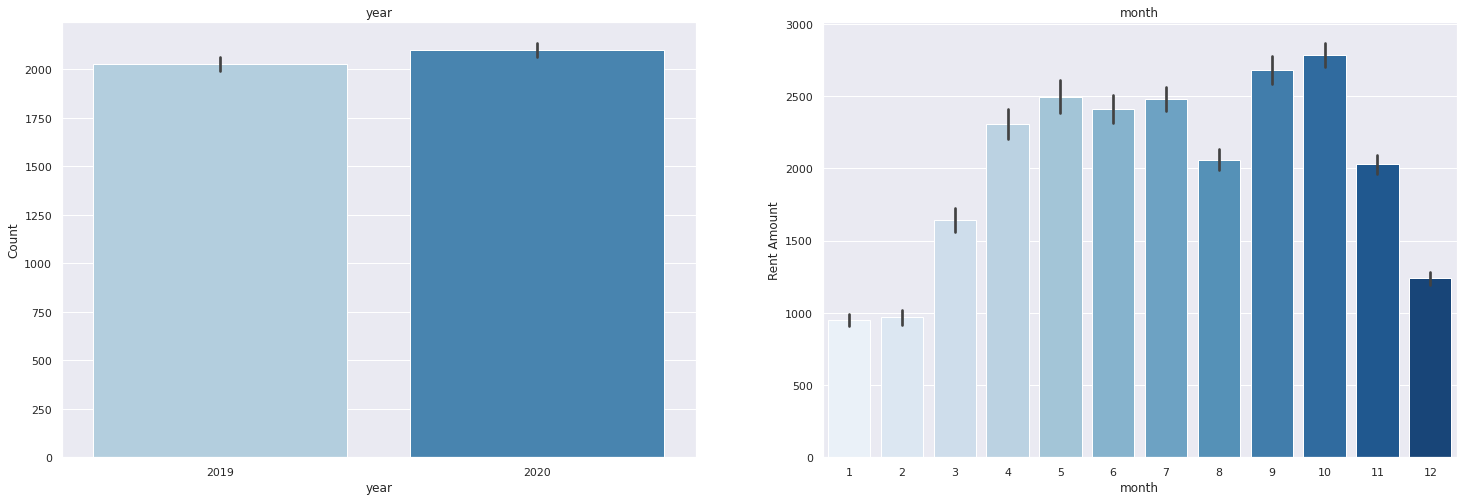

In [ ]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(25,8)

sns.barplot(data=df, x="year", y="Rent Amount", ax=ax1, palette='Blues')
sns.barplot(data=df, x="month", y="Rent Amount", ax=ax2, palette='Blues')

ax1.set(ylabel='Count',title="year")
ax2.set(xlabel='month',title="month")

In [ ]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

df["year_month"] = df["Date"].apply(concatenate_year_month)

print(df.shape)
df[["Date", "year_month"]].head()

(13121, 15)


,Date,year_month
0,2019-06-01,2019-6
1,2019-06-01,2019-6
2,2019-06-01,2019-6
3,2019-06-01,2019-6
4,2019-06-01,2019-6


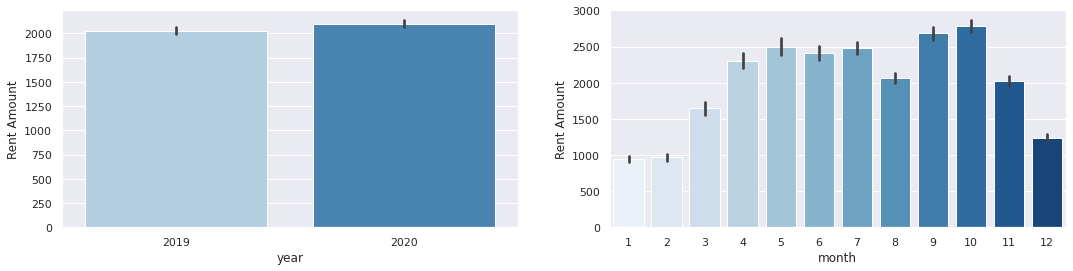

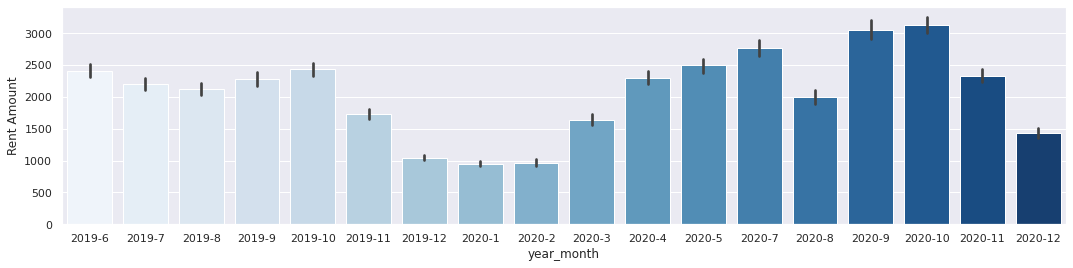

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=df, x="year", y="Rent Amount", ax=ax1, palette='Blues')
sns.barplot(data=df, x="month", y="Rent Amount", ax=ax2, palette='Blues')

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=df, x="year_month", y="Rent Amount", ax=ax3, palette='Blues' )

#2020 대여량이 더 많고, 증가하는 추세이다. 

## 변수들 간의 상관관계 확인
`Rainfall`, `Windspeed`, `Humidity`, `Dewpoint`, `Snow`, `Visibility`, `Rent Amount` Feature 간의 상관관계를 시각화합니다.

             Rainfall  Windspeed  Humidity  ...      Snow  Visibility  Rent Amount
Rainfall     1.000000   0.073263  0.212356  ... -0.007588   -0.187501    -0.149637
Windspeed    0.073263   1.000000 -0.217641  ...  0.089737    0.130725     0.149132
Humidity     0.212356  -0.217641  1.000000  ... -0.001918   -0.512215    -0.300894
Dewpoint     0.143710  -0.121839  0.606989  ... -0.156169   -0.208833     0.218797
Snow        -0.007588   0.089737 -0.001918  ...  1.000000   -0.005997    -0.093287
Visibility  -0.187501   0.130725 -0.512215  ... -0.005997    1.000000     0.254544
Rent Amount -0.149637   0.149132 -0.300894  ... -0.093287    0.254544     1.000000

[7 rows x 7 columns]


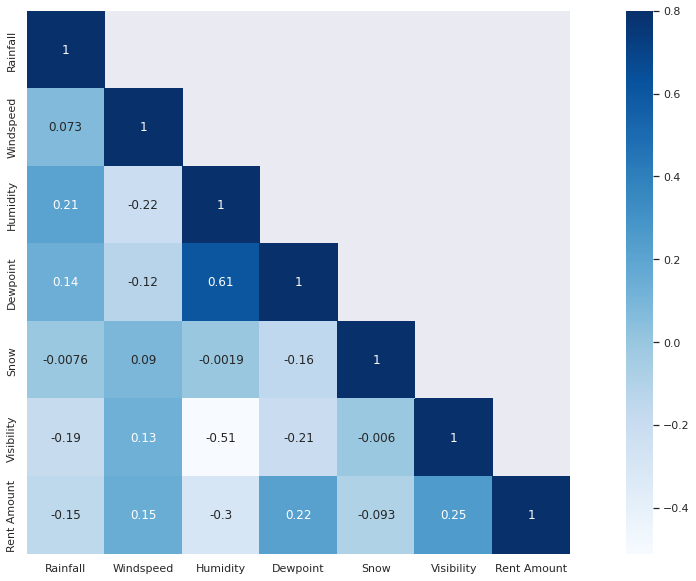

In [ ]:
#상관관계
corrMatt = dat[["Rainfall", "Windspeed", "Humidity", "Dewpoint", "Snow", "Visibility",'Rent Amount']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True,cmap='Blues')

## 시간대별 대여량 확인

In [ ]:
df["dayofweek"] = df["Date"].dt.dayofweek
df.shape
df["dayofweek"].value_counts()

6    1886
3    1883
5    1874
1    1874
0    1874
2    1868
4    1862
Name: dayofweek, dtype: int64

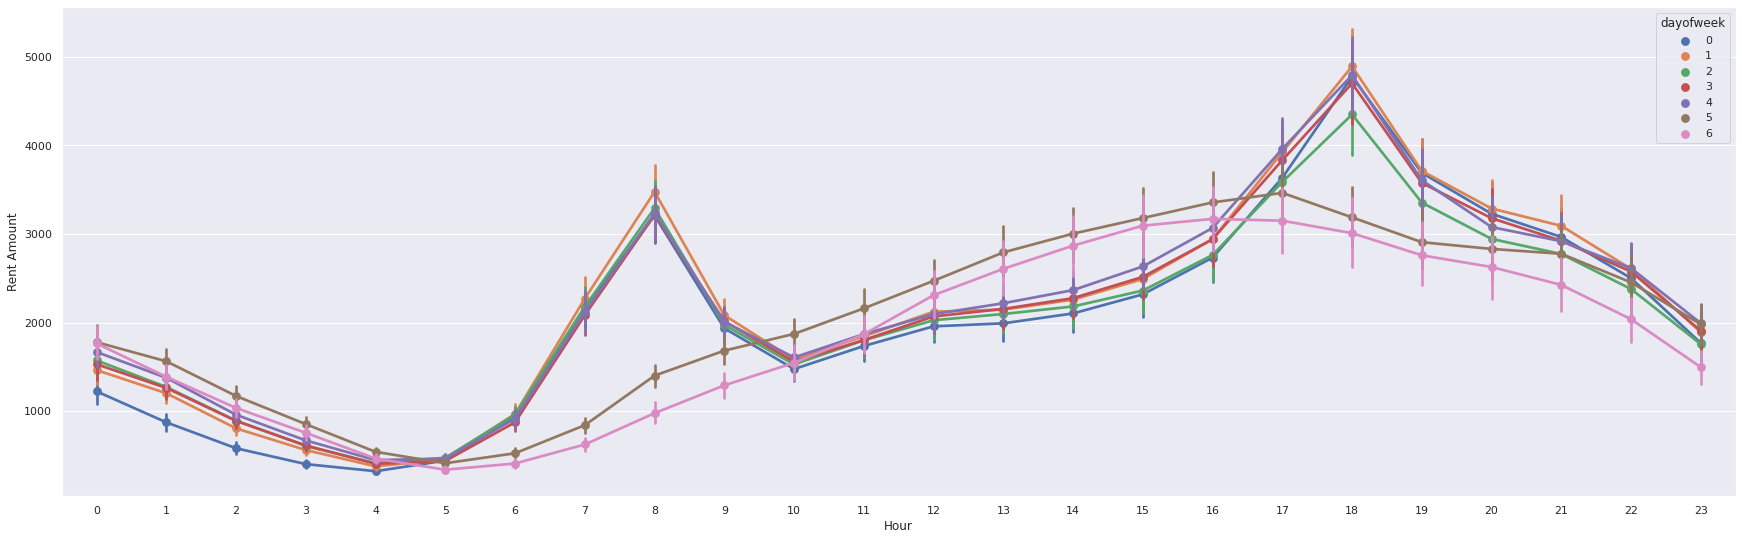

In [ ]:
fig,(ax2)= plt.subplots(nrows=1)
fig.set_size_inches(30,9)

sns.pointplot(data=df, x="Hour", y="Rent Amount", hue="dayofweek", ax=ax2)

* 주중 - 출퇴근 시간의 대여량이 높다는 것을 확인할 수 있습니다. 
* 주말 - 오후 시간대의 대여량이 높다는 것을 확인할 수 있습니다. 
* 주중/주말 여부에 따라 대여량 추이가 다르다는 것을 알 수 있습니다. 